# Исследование метрик для оценки сегментации медицинских изображений, корреляционный анализ метрик, построение моделей.

Перечень метрик и обоснование выбора [тут](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4533825/).

Гипотеза -- метрики для оценки сегментации коррелируют с мнением эксперта.

Задачи:
1. Расчитать метрики по всем парам масок (референсная и предсказаная).
2. Установить силу корреляции между каждой метрикой и мнением эксперта.
3. Ранжировать метрики относительно коэффициента корреляции.
4. Выбрать перечень наиболее оптимальных.
5. Построить регрессионную модель

In [1]:
import os
import re
import subprocess
from typing import Iterator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kendalltau

In [2]:
doc_eval_path = "../dataset/OpenPart.csv"
doc_no_eval_path = "../dataset/SecretPart_dummy.csv"
df_eval = pd.read_csv(doc_eval_path)
df_no_eval = pd.read_csv(doc_no_eval_path)

In [3]:
df = pd.concat([df_eval, df_no_eval])
df.reset_index(drop=True, inplace=True)

In [4]:
dir_samples = {
    "1": "../dataset/sample_1/",
    "2": "../dataset/sample_2/",
    "3": "../dataset/sample_3/",
}
dir_orig = "../dataset/Origin/"
dir_truth_mask = "../dataset/Expert"

### Добавляем к каждому семплу путь к изображению

In [5]:
for k, p in dir_samples.items():
    df["path_mask" + k] = [
        os.path.join(p, os.path.splitext(c)[0] + "_s" + k + ".png") for c in df.Case.values
    ]

In [6]:
df["path_truth_mask"] = [
    os.path.join(dir_truth_mask, os.path.splitext(c)[0] + "_expert" + ".png") for c in df.Case.values
]
df["path_orig"] = [os.path.join(dir_orig, c) for c in df.Case.values]

### Для удобства расчетов объединяем все семплы в одну колонку

In [7]:
path_list_pred_mask = np.concatenate((df.path_mask1, df.path_mask2, df.path_mask3))
path_list_truth_mask = np.concatenate((df.path_truth_mask, df.path_truth_mask, df.path_truth_mask))
evaluations = np.concatenate((df["Sample 1"], df["Sample 2"], df["Sample 3"]))
cases = np.concatenate( (df.Case, df.Case, df.Case) )
path_orig = np.concatenate( (df.path_orig, df.path_orig, df.path_orig) )

In [8]:
df = pd.DataFrame({
    "case": cases,
    "path_orig": path_orig,
    "path_pred_mask": path_list_pred_mask,
    "path_truth_mask": path_list_truth_mask,
    "expert_evaluation": evaluations,
})

In [9]:
df

,case,path_orig,path_pred_mask,path_truth_mask,expert_evaluation
0,00000072_000.png,../dataset/Origin/00000072_000.png,../dataset/sample_1/00000072_000_s1.png,../dataset/Expert/00000072_000_expert.png,1
1,00000150_002.png,../dataset/Origin/00000150_002.png,../dataset/sample_1/00000150_002_s1.png,../dataset/Expert/00000150_002_expert.png,5
2,00000181_061.png,../dataset/Origin/00000181_061.png,../dataset/sample_1/00000181_061_s1.png,../dataset/Expert/00000181_061_expert.png,4
3,00000211_019.png,../dataset/Origin/00000211_019.png,../dataset/sample_1/00000211_019_s1.png,../dataset/Expert/00000211_019_expert.png,4
4,00000211_041.png,../dataset/Origin/00000211_041.png,../dataset/sample_1/00000211_041_s1.png,../dataset/Expert/00000211_041_expert.png,3
...,...,...,...,...,...
295,00019124_090.png,../dataset/Origin/00019124_090.png,../dataset/sample_3/00019124_090_s3.png,../dataset/Expert/00019124_090_expert.png,0
296,00019495_004.png,../dataset/Origin/00019495_004.png,../dataset/sample_3/00019495_004_s3.png,../dataset/Expert/00019495_004_expert.png,0
297,00019767_016.png,../dataset/Origin/00019767_016.png,../dataset/sample_3/00019767_016_s3.png,../dataset/Expert/00019767_016_expert.png,0
298,00020000_000.png,../dataset/Origin/00020000_000.png,../dataset/sample_3/00020000_000_s3.png,../dataset/Expert/00020000_000_expert.png,0


Расчет метрик осуществляется поверх свободно распостраняемой программы [EvaluateSegmentation](https://github.com/Visceral-Project/EvaluateSegmentation).

In [10]:
def _calc_metrics(path_truth_mask, path_mask):
    metrics = subprocess.run(['./evaluate',
                              path_truth_mask,
                              path_mask],
                              cwd=os.path.realpath(os.path.join(os.getcwd())),
                              capture_output=True) # перенаправление потока вывода
    metrics = metrics.stdout.decode("utf-8").strip()
    regex = r"([A-Z]+)\s+=\s([\.\d]+)\s+[\w\(\)\-,\s]+\s?$"
    metrics = re.findall(regex, metrics, re.MULTILINE)
    return metrics

def calc_metrics(df):
    i = 0
    for truth, pred in zip(df.path_truth_mask.values, df.path_pred_mask.values):
        metrics = _calc_metrics(truth, pred)
        if metrics:
            for m in metrics:
                name, val = m
                val = float(val)
                df[name].values[i] = val
        i += 1
        print(str(i) + "/300")
    return df

In [6]:
metrics_names = ["DICE", "JACRD","AUC", "KAPPA", "RNDIND", "ADJRIND",
                "ICCORR","VOLSMTY", "MUTINF", "HDRFDST", "AVGDIST",
                "AVD", "MAHLNBS", "VARINFO", "GCOERR", "PROBDST",
                "SNSVTY", "SPCFTY", "PRCISON", "FMEASR", "ACURCY",
                "FALLOUT", "TP", "FP", "TN", "FN", "REFVOL", "SEGVOL"]

In [12]:
for name in metrics_names:
    df[name] = np.nan

In [13]:
%%time
df = calc_metrics(df)

1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300
30/300
31/300
32/300
33/300
34/300
35/300
36/300
37/300
38/300
39/300
40/300
41/300
42/300
43/300
44/300
45/300
46/300
47/300
48/300
49/300
50/300
51/300
52/300
53/300
54/300
55/300
56/300
57/300
58/300
59/300
60/300
61/300
62/300
63/300
64/300
65/300
66/300
67/300
68/300
69/300
70/300
71/300
72/300
73/300
74/300
75/300
76/300
77/300
78/300
79/300
80/300
81/300
82/300
83/300
84/300
85/300
86/300
87/300
88/300
89/300
90/300
91/300
92/300
93/300
94/300
95/300
96/300
97/300
98/300
99/300
100/300
101/300
102/300
103/300
104/300
105/300
106/300
107/300
108/300
109/300
110/300
111/300
112/300
113/300
114/300
115/300
116/300
117/300
118/300
119/300
120/300
121/300
122/300
123/300
124/300
125/300
126/300
127/300
128/300
129/300
130/300
131/300
132/300
133/300
134/300
135/300
136/300
137/300
138/300
139/

In [14]:
df

,case,path_orig,path_pred_mask,path_truth_mask,expert_evaluation,DICE,JACRD,AUC,KAPPA,RNDIND,...,PRCISON,FMEASR,ACURCY,FALLOUT,TP,FP,TN,FN,REFVOL,SEGVOL
0,00000072_000.png,../dataset/Origin/00000072_000.png,../dataset/sample_1/00000072_000_s1.png,../dataset/Expert/00000072_000_expert.png,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000150_002.png,../dataset/Origin/00000150_002.png,../dataset/sample_1/00000150_002_s1.png,../dataset/Expert/00000150_002_expert.png,5,0.520065,0.351411,0.675705,0.519415,0.996630,...,1.000000,0.520065,0.998312,0.000000,959.0,0.0,1045847.0,1770.0,2729.0,959.0
2,00000181_061.png,../dataset/Origin/00000181_061.png,../dataset/sample_1/00000181_061_s1.png,../dataset/Expert/00000181_061_expert.png,4,0.519559,0.350949,0.935726,0.473689,0.807597,...,0.352818,0.519559,0.892172,0.113676,61136.0,112143.0,874374.0,923.0,62059.0,173279.0
3,00000211_019.png,../dataset/Origin/00000211_019.png,../dataset/sample_1/00000211_019_s1.png,../dataset/Expert/00000211_019_expert.png,4,0.708670,0.548791,0.936005,0.648735,0.806597,...,0.549853,0.708670,0.891534,0.124482,138332.0,113248.0,796509.0,487.0,138819.0,251580.0
4,00000211_041.png,../dataset/Origin/00000211_041.png,../dataset/sample_1/00000211_041_s1.png,../dataset/Expert/00000211_041_expert.png,3,0.562957,0.391747,0.872117,0.476487,0.716678,...,0.403945,0.562957,0.829149,0.184200,115382.0,170256.0,754044.0,8894.0,124276.0,285638.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,00019124_090.png,../dataset/Origin/00019124_090.png,../dataset/sample_3/00019124_090_s3.png,../dataset/Expert/00019124_090_expert.png,0,0.156904,0.085131,0.543202,0.146306,0.903850,...,0.670239,0.156904,0.949361,0.002448,4941.0,2431.0,990536.0,50668.0,55609.0,7372.0
296,00019495_004.png,../dataset/Origin/00019495_004.png,../dataset/sample_3/00019495_004_s3.png,../dataset/Expert/00019495_004_expert.png,0,0.253342,0.145044,0.590372,0.247273,0.972375,...,0.405203,0.253342,0.985991,0.003534,2492.0,3658.0,1031395.0,11031.0,13523.0,6150.0
297,00019767_016.png,../dataset/Origin/00019767_016.png,../dataset/sample_3/00019767_016_s3.png,../dataset/Expert/00019767_016_expert.png,0,0.000000,0.000000,0.486373,NaN,0.895432,...,0.000000,0.000000,0.944653,0.027254,0.0,27753.0,990540.0,30283.0,30283.0,27753.0
298,00020000_000.png,../dataset/Origin/00020000_000.png,../dataset/sample_3/00020000_000_s3.png,../dataset/Expert/00020000_000_expert.png,0,0.646104,0.477219,0.783067,0.619247,0.904161,...,0.720684,0.646104,0.949533,0.019379,48306.0,18722.0,947352.0,34196.0,82502.0,67028.0


In [28]:
df.to_csv("table.csv", index=False)

In [7]:
M = {}
for name in metrics_names:
    M[name] = df[name].values

### Анализ

1. plot -- визуализация зависимости метрики и мнения врача (OX - мнение врача, OY - метрика)
2. get_correlation_coef -- расчет коэффициента корреляции Кенделла, причина выбора указана [тут](https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall).
3. sort_metrics -- сортировка метрик в зависимости от коэффициента корреляции

In [8]:
def plot(df, col_names):
    x = df.expert_evaluation
    for name in col_names:
        title = name
        y = df[name].values
        
        if np.max(y) >= 1000:
            y = np.log(y)
            title += " (ln)"
            
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.set_title(title)
        plt.plot(x, y, "bo");
        
def get_correlation_coef(ground_truth: np.array, metric: np.array) -> float:
    return kendalltau(ground_truth, metric).correlation

def sort_metrics(ground_truth, metrics):
    c = {}
    for metric, pred in metrics.items():
        c[metric] = get_correlation_coef(ground_truth, pred)

    return {k: v for k, v in sorted(c.items(), key=lambda item: item[1], reverse=True)}

<ipython-input-8-a24fa12f42ab>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
<ipython-input-8-a24fa12f42ab>:8: RuntimeWarning: divide by zero encountered in log
  y = np.log(y)
<ipython-input-8-a24fa12f42ab>:8: RuntimeWarning: divide by zero encountered in log
  y = np.log(y)


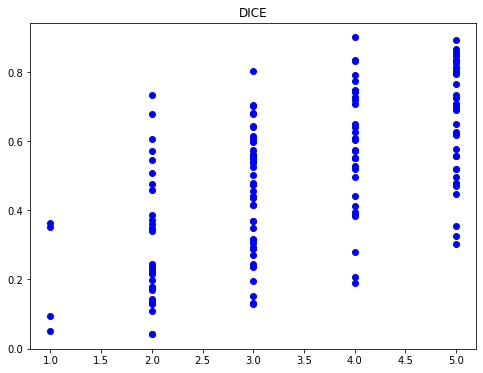

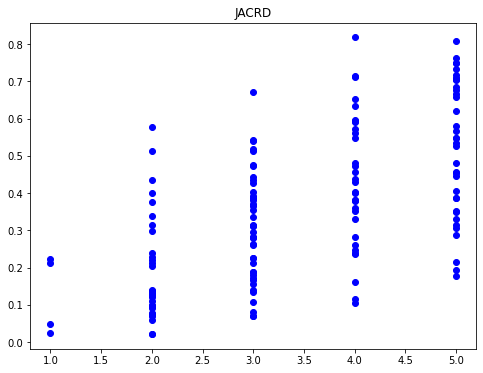

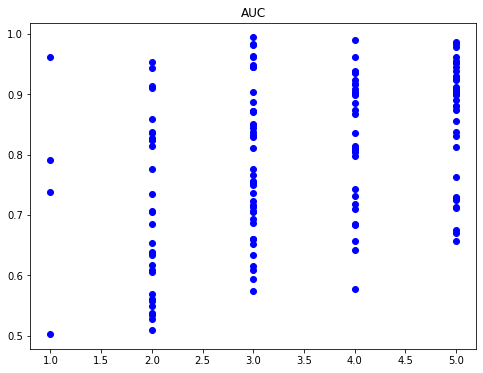

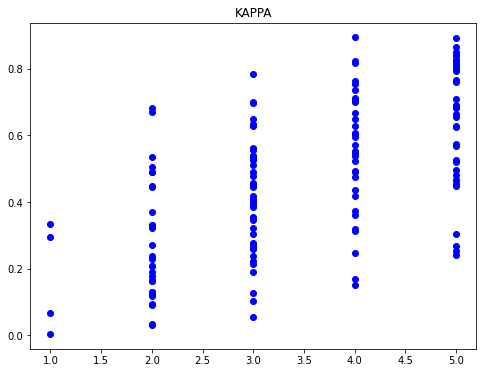

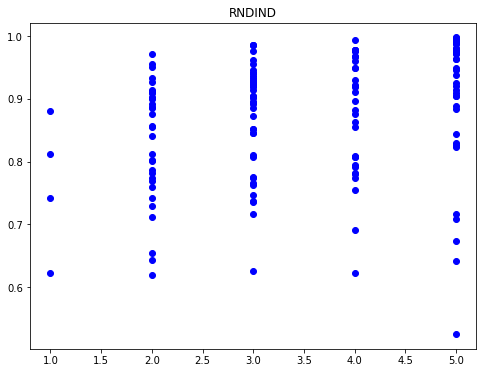

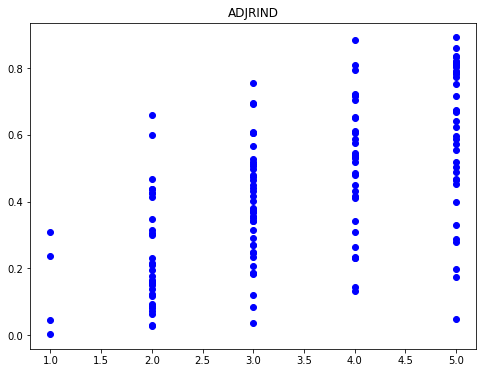

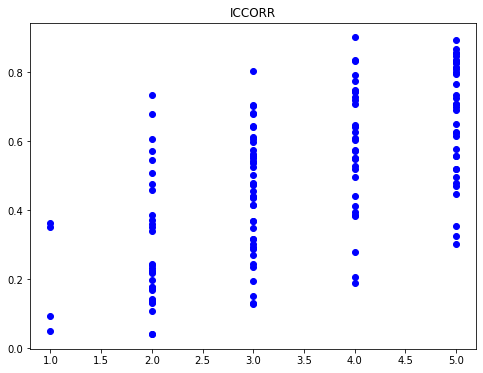

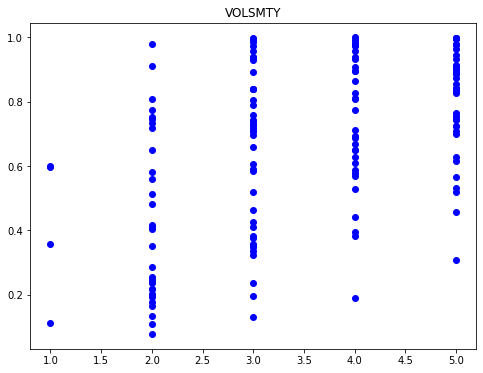

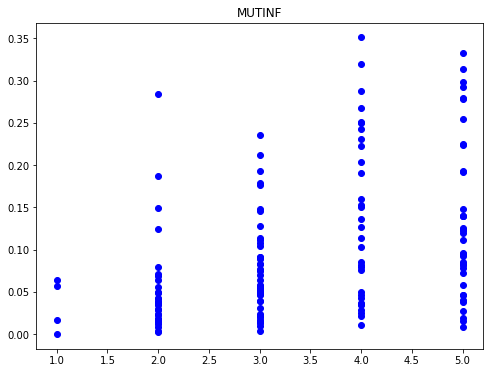

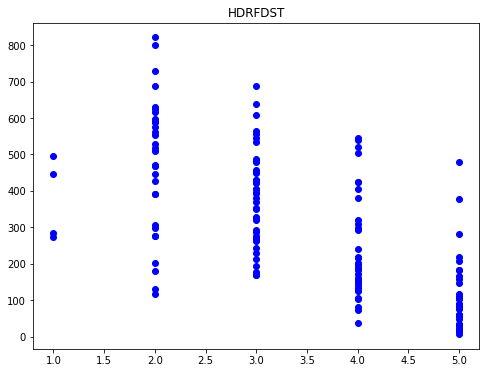

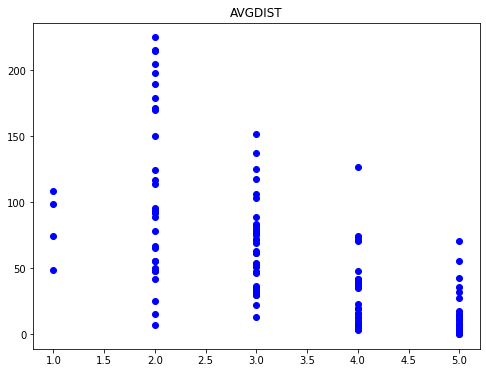

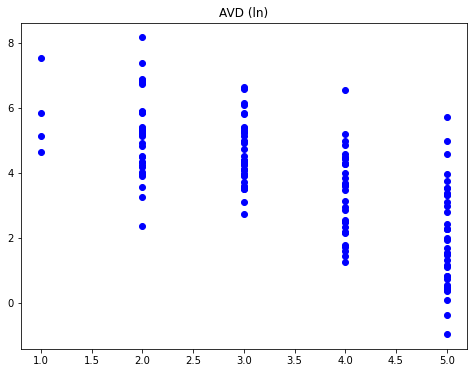

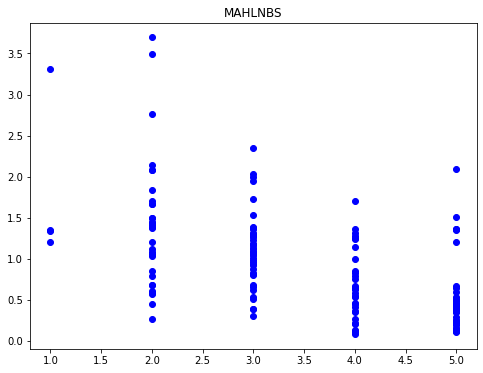

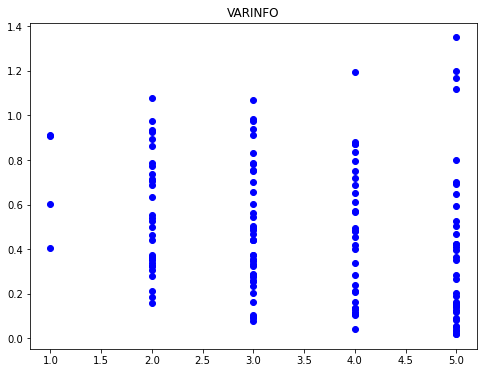

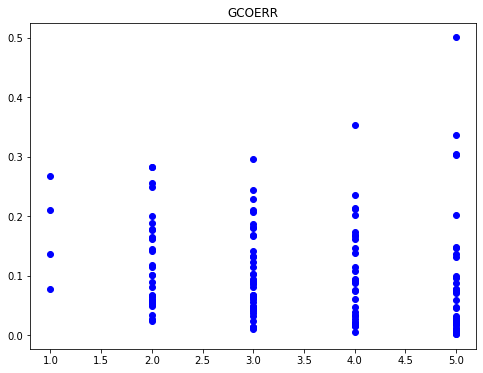

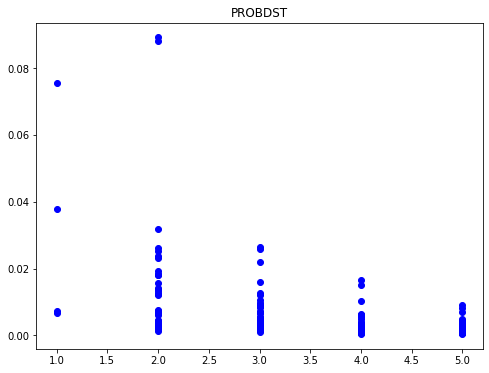

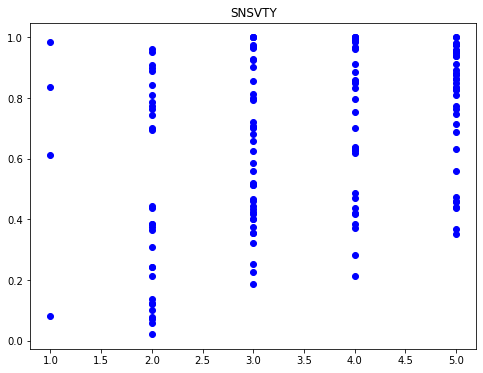

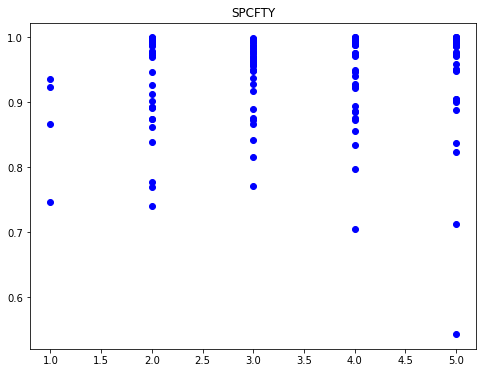

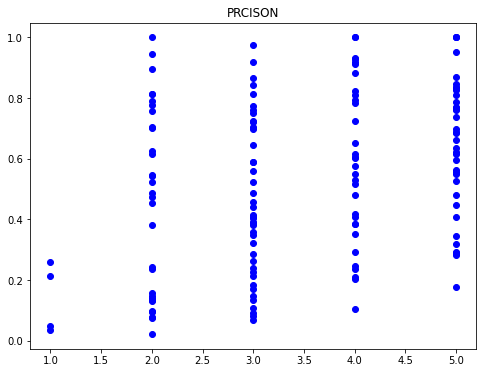

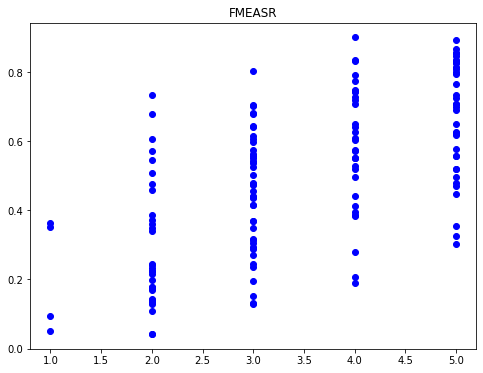

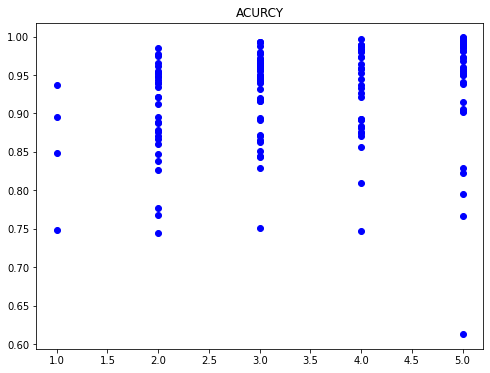

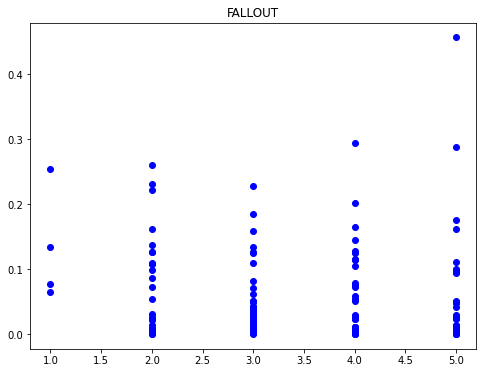

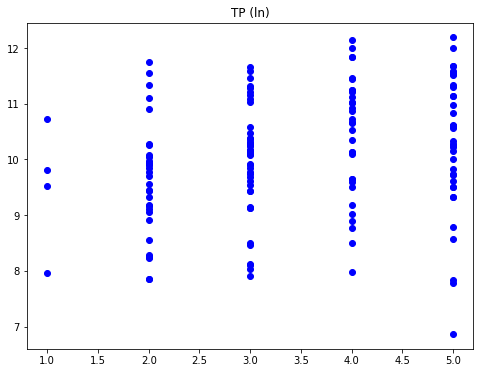

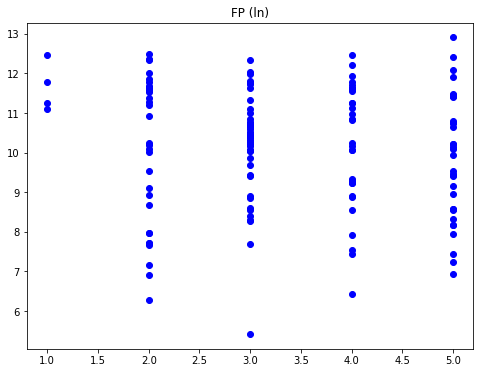

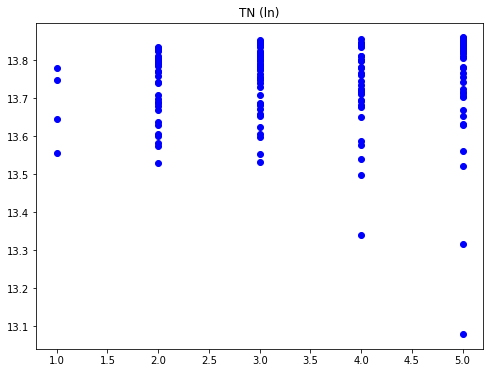

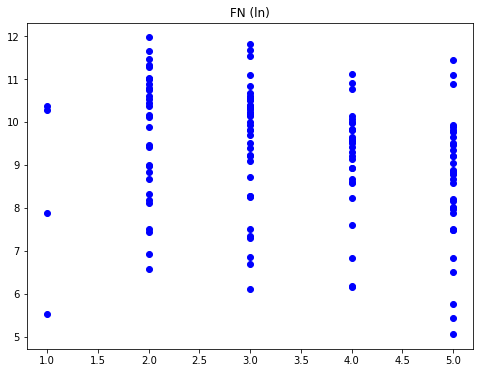

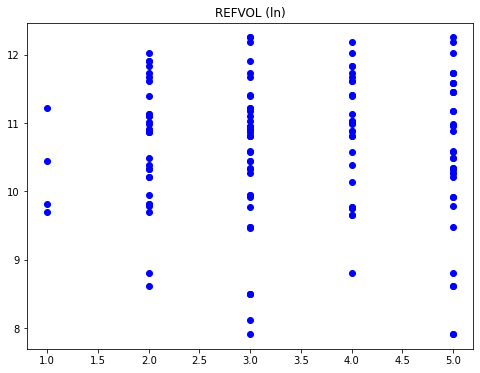

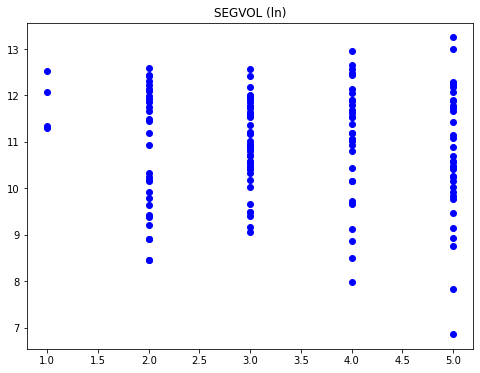

In [9]:
plot(df, metrics_names)

In [10]:
for m, x in M.items():
    if np.max(x) > 1000:
        print(m)
        M[m] = np.log(x)

AVD
TP
FP
TN
FN
REFVOL
SEGVOL


<ipython-input-10-2e905a6bf32c>:4: RuntimeWarning: divide by zero encountered in log
  M[m] = np.log(x)


In [11]:
ground_truth = df.expert_evaluation.values

In [12]:
sorted_metrics = sort_metrics(ground_truth, M)

In [13]:
top = {}
t = 0.4

for name, val in sorted_metrics.items():
    if abs(val) > t:
        top[name] = val

In [14]:
sorted_metrics

{'DICE': 0.4883102151657906,
 'JACRD': 0.4883102151657906,
 'ICCORR': 0.4883102151657906,
 'FMEASR': 0.4883102151657906,
 'KAPPA': 0.4775045011767269,
 'ADJRIND': 0.46324095871116266,
 'VOLSMTY': 0.35259044746315,
 'MUTINF': 0.3307629052052412,
 'AUC': 0.3048291916314882,
 'RNDIND': 0.2644158213123898,
 'ACURCY': 0.2644158213123898,
 'SNSVTY': 0.26324707408006176,
 'PRCISON': 0.24762636817539901,
 'TP': 0.20282325157472647,
 'TN': 0.11940313957915437,
 'SPCFTY': 0.10034815269291278,
 'REFVOL': 0.021858282419983666,
 'SEGVOL': -0.004214427535899165,
 'FALLOUT': -0.10034815269291278,
 'FP': -0.10315963110887802,
 'VARINFO': -0.1991493088184448,
 'GCOERR': -0.20347159441407028,
 'FN': -0.23032765387424572,
 'MAHLNBS': -0.45113855904341127,
 'PROBDST': -0.4883102151657906,
 'AVD': -0.5455804993078284,
 'HDRFDST': -0.5566286214722205,
 'AVGDIST': -0.5993929549733659}

In [75]:
top

{'DICE': 0.4883102151657906,
 'JACRD': 0.4883102151657906,
 'ICCORR': 0.4883102151657906,
 'FMEASR': 0.4883102151657906,
 'KAPPA': 0.4775045011767269,
 'ADJRIND': 0.46324095871116266,
 'MAHLNBS': -0.45113855904341127,
 'PROBDST': -0.4883102151657906,
 'AVD': -0.5455804993078284,
 'HDRFDST': -0.5566286214722205,
 'AVGDIST': -0.5993929549733659}

In [39]:
pd.DataFrame(sorted_metrics, index=[0]).to_csv("sorted_metrics.csv", index=False)
pd.DataFrame(top, index=[0]).to_csv("top.csv", index=False)

### Импортируем используемые модели

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [82]:
X = df[top.keys()].values
y = df.expert_evaluation.values

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [84]:
models = [LinearRegression(),
          RandomForestRegressor(n_estimators=100, max_features ='sqrt'),
          KNeighborsRegressor(n_neighbors=6),
          SVR(kernel='linear'),
          LogisticRegression(),
          Lasso(alpha=0.1),
         ]

In [85]:
for m in models:
    print(m)
    m.fit(X_train, y_train)
    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)
    
    print('Mean AE train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
    print('Median AE train: {:.3f}, test: {:.3f}'.format(
        median_absolute_error(y_train, y_train_pred),
        median_absolute_error(y_test, y_test_pred)))
    print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
    print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
    print()

LinearRegression()
Mean AE train: 0.648, test: 0.659
Median AE train: 0.505, test: 0.428
MSE train: 0.700, test: 0.915
R^2 train: 0.485, test: 0.292

RandomForestRegressor(max_features='sqrt')
Mean AE train: 0.255, test: 0.458
Median AE train: 0.175, test: 0.370
MSE train: 0.131, test: 0.370
R^2 train: 0.903, test: 0.713

KNeighborsRegressor(n_neighbors=6)
Mean AE train: 0.626, test: 0.485
Median AE train: 0.500, test: 0.500
MSE train: 0.692, test: 0.376
R^2 train: 0.491, test: 0.709

SVR(kernel='linear')
Mean AE train: 0.659, test: 0.497
Median AE train: 0.451, test: 0.430
MSE train: 0.829, test: 0.397
R^2 train: 0.391, test: 0.692

LogisticRegression()
Mean AE train: 0.608, test: 0.500
Median AE train: 0.000, test: 0.500
MSE train: 0.980, test: 0.500
R^2 train: 0.279, test: 0.613

Lasso(alpha=0.1)
Mean AE train: 0.698, test: 0.601
Median AE train: 0.595, test: 0.617
MSE train: 0.803, test: 0.490
R^2 train: 0.409, test: 0.621



/home/erkh/ScienceToolbox/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
